In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import datetime
import string
from string import digits
import collections
import scipy.stats as scs
import cc_pipeline as P
import time
import random
import pickle
from pprint import pprint
from collections import Counter

#sentiment and language
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import vaderSentiment
from langdetect import detect
from gensim.models import Word2Vec
from gensim import corpora
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy import displacy

#machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.ldamodel import LdaModel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
import knee_locator

#plotting
from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, BoxSelectTool
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import pyLDAvis.sklearn
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import umap

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Structure

In [11]:
df = pd.read_csv('data/captions_.csv', encoding='utf=8')
df.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned,language,stations
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...,knock door knew only that still knock have doo...,en,WBNX HD CW
1,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702,"1538437521225\n1435\nSeen it, covered it.\n\n1...",seen covered know thing seen thing farmer burk...,en,KZJO MY NETWORK SEATTLE
2,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995,1538435707355\n4571\n\n\n\n1538435711926\n23...,look your traffic report look your traffic rep...,en,WVUA THIS TV BIRMINGHAM
3,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925,1538437500869\n2653\nWe’ll talk later.\n\n1538...,talk later right back verdict sidney guess som...,en,TV LAND
4,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074,1538437500144\n1201\nIt hurts.\n\n153843750218...,hurt heart lost murr kid friend play video gam...,en,WPCH INDEPENDENT ATLANTA


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51973 entries, 0 to 51972
Data columns (total 16 columns):
_id           51973 non-null object
channel       51973 non-null object
created_at    51973 non-null object
duration      51973 non-null int64
lang          51973 non-null object
machine_id    51973 non-null object
ts            51973 non-null object
tui           51973 non-null int64
tv            51973 non-null object
url           51973 non-null object
zip_url       51973 non-null object
date          51973 non-null object
text          51973 non-null object
cleaned       51973 non-null object
language      51973 non-null object
stations      51973 non-null object
dtypes: int64(2), object(14)
memory usage: 6.3+ MB


In [5]:
df.describe()

,duration,tui
count,51973.0,5.197300e+04
mean,900000.0,2.547169e+08
std,0.0,2.127712e+07
min,900000.0,2.515332e+08
25%,900000.0,2.515362e+08
50%,900000.0,2.515387e+08
75%,900000.0,2.515463e+08
max,900000.0,4.106483e+08


In [7]:
#raw caption text

print(df['text'][0])

1538437621406
1835
[ KNOCK ON DOOR ]

1538437623274
1034
HEY, DAD.

1538437624343
968
SON.

1538437625344
1268
KNEW IT WAS YOU.

1538437626645
1502
YOU’RE THE ONLY ONE
THAT STILL KNOCKS.

1538437628180
1301
WE HAVE A DOORBELL.

1538437629514
1368
OH, FORGIVE ME
FOR TRYING TO SAVE YOU

1538437630916
1502
A COUPLE OF BUCKS
ON ELECTRICITY.

1538437634086
2636
I LEFT MY NICOTINE GUM HERE
THE OTHER NIGHT.

1538437636755
1368
I REALLY NEED IT

1538437638156
2436
SINCE I SWITCHED
TO THOSE LIGHT CIGARETTES.

1538437640626
1668
SO THAT’S
WHAT THAT IS.

1538437642327
2336
I THOUGHT IT WAS A CHICLET
THAT HAD GONE BAD.

1538437644696
1969
EXPLAINS WHY I COULDN’T STOP
CHEWING IT.

1538437648166
1702
IT’S A PRETTY GOOD GAME.

1538437649901
2035
WANT TO STICK AROUND
AND WATCH?

1538437651970
2236
I GUESS.

1538437654239
2035
YOU KNOW,
THE OTHER NIGHT,

1538437656307
2536
WHEN I WAS TALKING
ABOUT SPANKING,

1538437658877
2569
I THINK YOU MIGHT HAVE
TAKEN ME THE WRONG WAY.

1538437661479
1368
YOU WERE 

In [9]:
#cleaned caption text

print(df['cleaned'][0])

knock door knew only that still knock have doorbell forgive trying save couple buck electricity left nicotine here other night really need since switched those light cigarette that what that thought chiclet that gone explains couldn stop chewing pretty good game want stick around watch guess know other night when talking about spanking think might have taken wrong were pretty clear much open that would look spanked knew know never took well wasn giving fastball just saying nothing didn deserve kid shouldn throwing each other window lighting each other fire stealing stole that dent bonneville that where jimmy landed when tossed window great raising been thinking about really some damage with that hitting fault turned what smart handsome successful know sensitive sensitive mean insensitive vanessa always complaining about something were sensitive could tell what rough result spank your kid that called self control sorry didn mean hurt your feeling know them what talking about remember on

## TF-IDF Vectorization - TruncatedSVD Dimensionality Reduction

In [12]:
text = df['cleaned'].values
text = text.tolist()

In [13]:
#including n_grams and max features
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,3), max_features=1000) 
tfidf_model = vectorizer.fit_transform(text)

#model more robust after including dimensionality reduction prior to KMeans
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

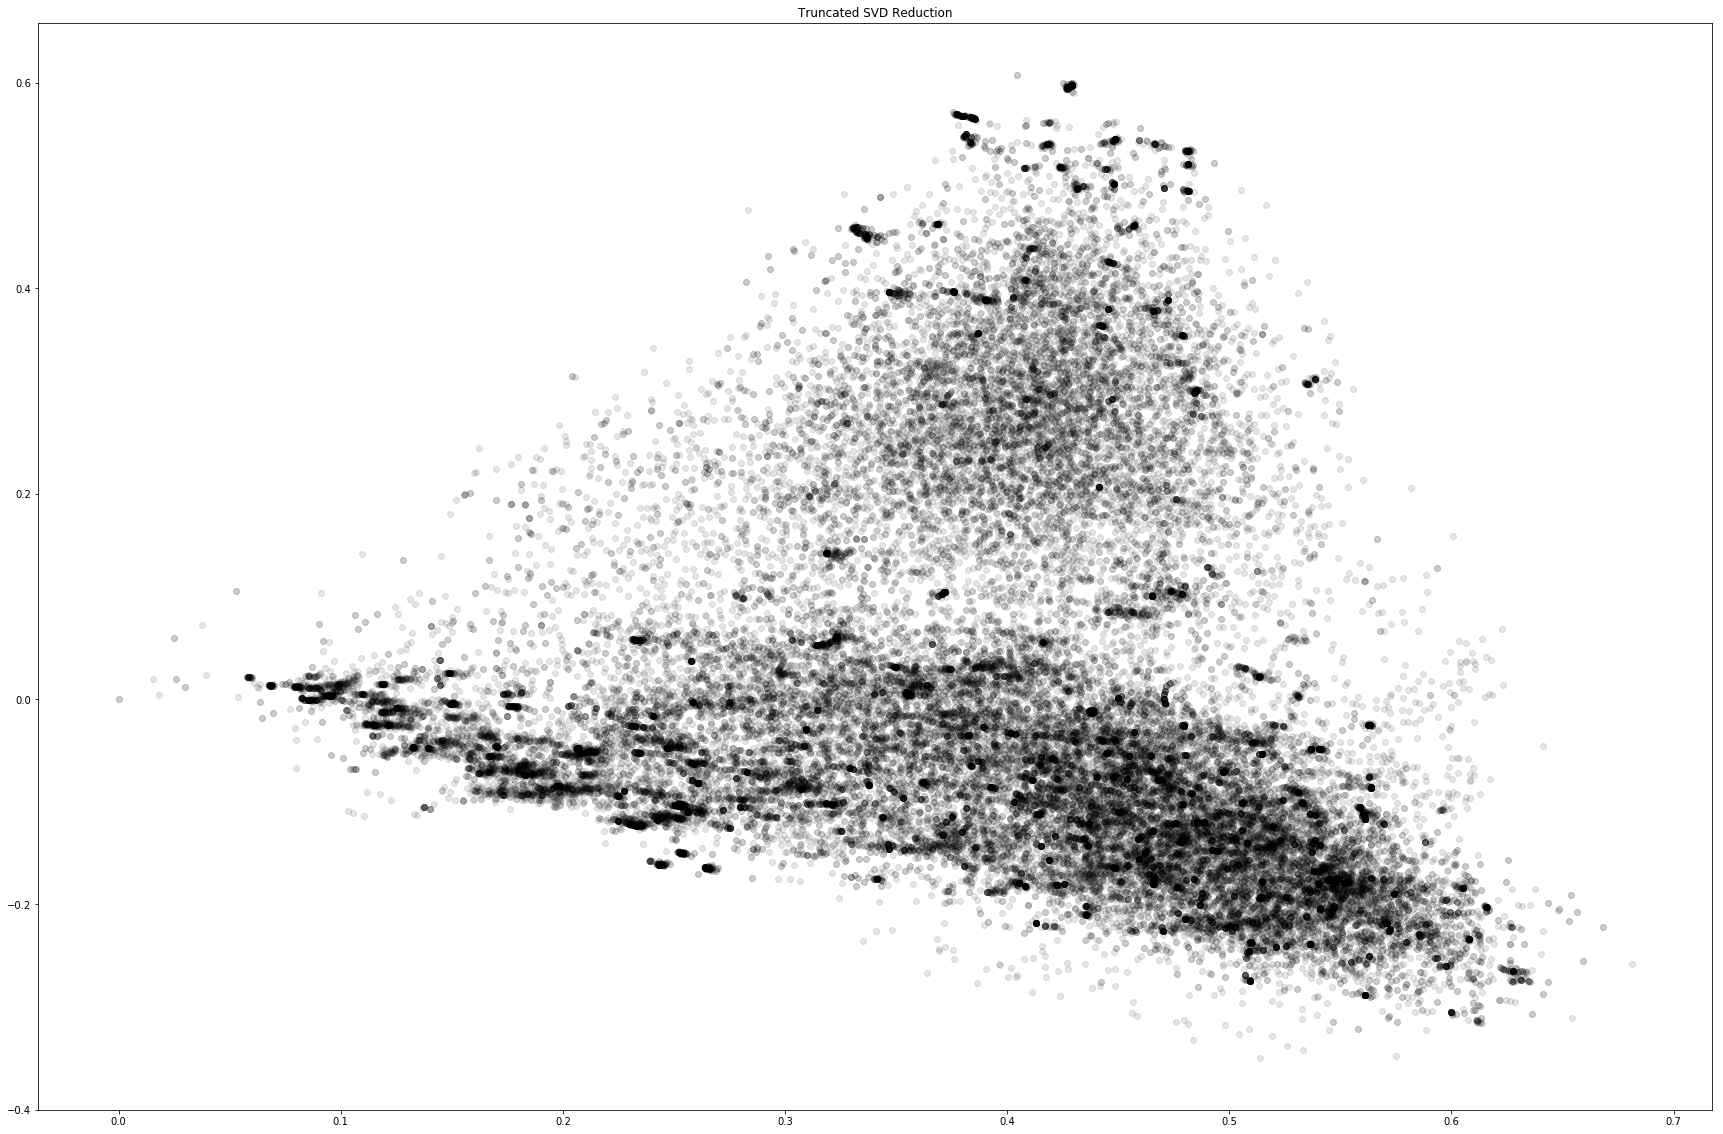

In [16]:
plt.figure(figsize=(30,20))
plt.scatter(clf[:,0], clf[:,1], c='k', alpha=0.1)
plt.title('Truncated SVD Reduction')
plt.show() 

## KMeans

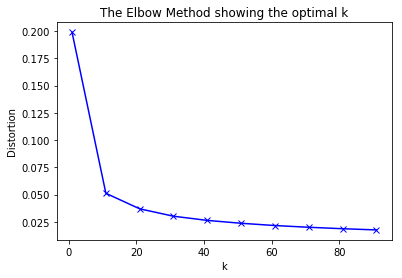

In [18]:
distortions = []
K = range(1,100,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1)
    kmeanModel.fit(clf)
    distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## LDA sklearn

In [ ]:
search_params = {'n_components': [25, 50, 100], 'learning_decay': [.5]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tfidf_model)
best_lda_model = model.best_estimator_

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 20}

In [19]:
best_lda_model = LatentDirichletAllocation(n_components=20, learning_decay=0.5, n_jobs=-1)
best_lda_model.fit(tfidf_model)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=20, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [20]:
def show_topics(vectorizer=vectorizer, lda_model=None, n_words=20):
    
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    return topic_keywords

In [21]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)     

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
0,nick,game,team,play,ball,player,coach,season,stephen,field,shot,played,defense,throw,second,pas,third,first,point,last
1,james,cheer applause cheer,applause cheer applause,applause cheer,stephen,defense,announced,judy,kavanaugh,emmy,accused,cloudy,humana,yard,central,katie,chip,football,eye,east
2,accused,defense,flake,announced,applause cheer,nick,cheer applause cheer,applause cheer applause,supreme court,stephen,harvey,katie,allegation,forecast,humana,kavanaugh,brett,mathis,thunderstorm,judy
3,accused,defense,flake,announced,applause cheer,nick,cheer applause cheer,applause cheer applause,supreme court,stephen,harvey,katie,allegation,forecast,humana,kavanaugh,brett,mathis,thunderstorm,judy
4,cheer applause,cheer,applause,applause cheer,applause cheer applause,cheer applause cheer,laughter,audience,welcome back,lady,final,laughter laughter,applause applause,welcome,jimmy,vote,show,song,right back,thank thank
5,accused,defense,flake,announced,applause cheer,nick,cheer applause cheer,applause cheer applause,supreme court,stephen,harvey,katie,allegation,forecast,humana,kavanaugh,brett,mathis,thunderstorm,judy
6,steve,cheering,answer,name,audience,applause,play,harvey,board,everybody,captioning,right back,welcome back,national,supreme court,accused,humana,defense,cheer applause cheer,applause cheer applause
7,murder,case,crime,victim,police,suspect,killed,found,defense,death,husband,information,jimmy,knew,blood,witness,kill,wife,told,dead
8,know,like,right,yeah,okay,want,think,good,going,well,time,come,back,love,look,really,thing,little,would,need
9,cardi,kanye,married,york,trump,video,donald,president,club,weekend,strip,wedding,show,said,chris,west,stage,source,come back,speaking
